In [1]:
%cd ..

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy

from PIL import Image
from torchvision import transforms
from utils import get_psnr, image_normalization
from alignment.alignment_utils import load_deep_jscc
from alignment.alignment_model import _LinearAlignment, AlignedDeepJSCC, _ConvolutionalAlignment

os.getcwd()
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

d:\File\Repos\Deep-JSCC-PyTorch


In [2]:
channel_type = 'AWGN'
model1_fp = r'alignment\models\upscaled_42.pkl'
# model1_fp = r'alignment\models\seed42_v1.pkl'

model2_fp = r'alignment\models\upscaled_43.pkl'
# model2_fp = r'alignment\models\seed43_v1.pkl'

aligner_fp = r'alignment\models\aligner_conv_imagenette.pkl'
# aligner_fp = r'alignment\models\aligner_conv.pkl'
# aligner_fp = r'alignment\models\aligner_32.pkl'
# aligner_fp = r'alignment\models\aligner_64.pkl'
# aligner_fp = r'alignment\models\aligner_64_cifar_upscaled.pkl'
# aligner_fp = r'alignment\models\aligner_64_cifar_upscaled_d.pkl'

snr = 7
test_image_dir = r'demo\kodim23.png'
times = 10
resolution = 256

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

c = 8

In [3]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])
transform = transforms.Compose([transforms.ToTensor(), ])
test_image = Image.open(test_image_dir)
test_image.load()
test_image = transform(test_image)

In [4]:
model1 = load_deep_jscc(model1_fp, snr, c, channel_type)
model2 = load_deep_jscc(model2_fp, snr, c, channel_type)

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

# with open(aligner_fp, 'rb') as f:
#     align_matrix = pickle.load(f)
# aligner = _LinearAlignment(align_matrix)

with open(aligner_fp, 'rb') as f:
    aligner = pickle.load(f)

aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel_type)
unaligned_model = AlignedDeepJSCC(encoder, decoder, None, snr, channel_type)

In [5]:
def evaluation_pipeline(model, upscale_factor=1):
    psnr_all = 0.0
    with torch.no_grad():
        for _ in range(times):
            demo_image = model(test_image)
            demo_image = image_normalization('denormalization')(demo_image)
            gt = image_normalization('denormalization')(test_image)
            psnr_all += get_psnr(demo_image, gt)

        # prepare image for visualization
        demo_image = image_normalization('normalization')(demo_image)
        demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)  # (C, H, W)
        demo_image = demo_image.numpy()  # (C, H, W)
        demo_image = demo_image.transpose(1, 2, 0)  # convert to (H, W, C) for PIL

        # convert to PIL image and upscale
        pil_image = Image.fromarray((demo_image * 255).astype(np.uint8))
        new_size = (pil_image.width * upscale_factor, pil_image.height * upscale_factor)
        pil_image = pil_image.resize(new_size, Image.NEAREST)  # Use NEAREST or BICUBIC

    # show the upscaled image
    plt.figure(figsize=(new_size[0] / 100, new_size[1] / 100), dpi=100)
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

    print("Average PSNR is {:.2f} over {} runs on {}".format(psnr_all.item() / times, times, os.path.basename(test_image_dir)))

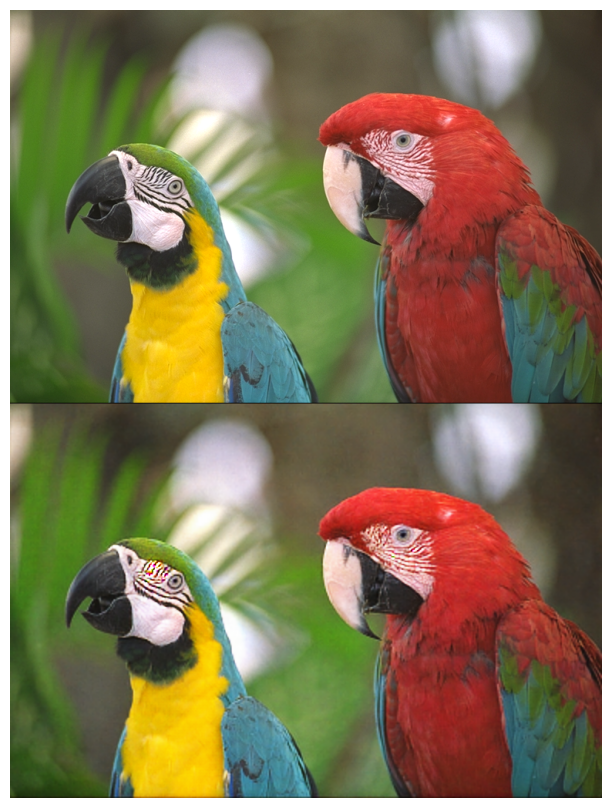

Average PSNR is 30.26 over 10 runs on kodim23.png


In [6]:
# without semantic mismatch
evaluation_pipeline(model1)

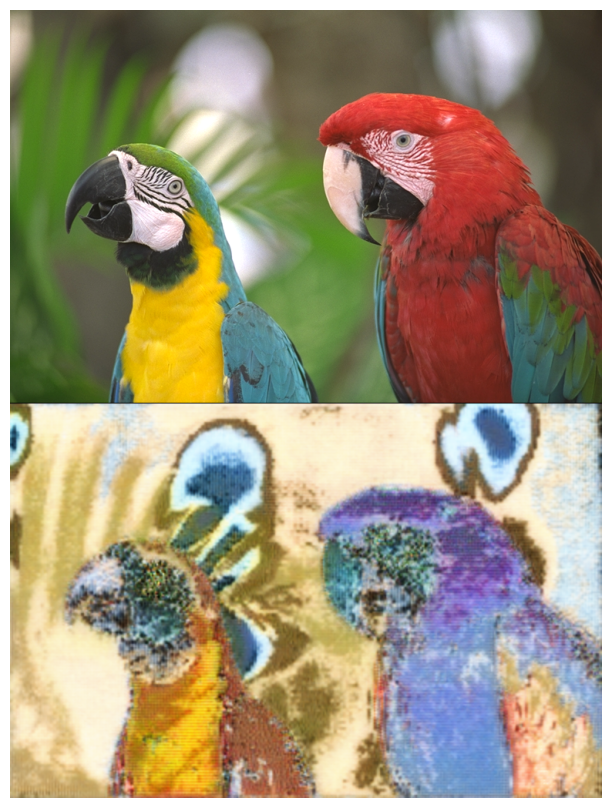

Average PSNR is 7.36 over 10 runs on kodim23.png


In [7]:
# with semantic mismatch, without aligning
evaluation_pipeline(unaligned_model)

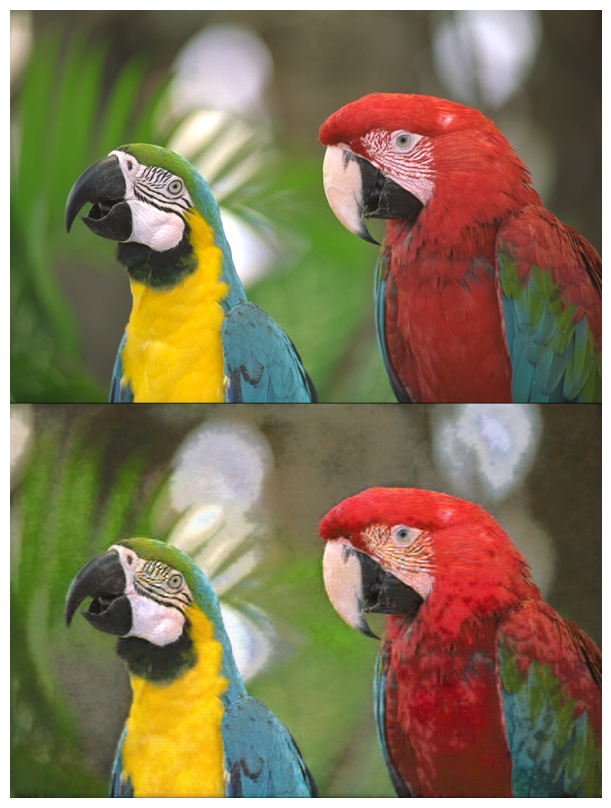

Average PSNR is 26.71 over 10 runs on kodim23.png


In [8]:
# with semantic mismatch, with aligning
evaluation_pipeline(aligned_model)